<a href="https://colab.research.google.com/github/bernicegolomo/DecisionTreeClassifier/blob/main/NR_project_DecisionTree_(withPCA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load the necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, mean_squared_error,
                             mean_absolute_error)
from sklearn.preprocessing import StandardScaler, LabelEncoder #, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# Read the Data

In [ ]:
# Load dataset
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/df.parquet.gzip') # df = pd.read_parquet('/content/enchanced_defm_data.parquet')

# df = pd.read_parquet('~/Downloads/NR_prj/df.parquet.gzip') #enchanced_defm_data.parquet

# Preview the data
print(df.head(2))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   TreeKey  HtToDBH  DBH  TreeMsrKey  TreeMsrKey.1  \
0     1879      1.3  3.5         593           593   
1     1910      1.4  3.1         624           624   

                  DefmCauseName  DefmCauseCode  DefmCauseTypeCode  \
0  Suppressed by adjacent trees            125                  5   
1    Physical (natural) unknown            118                  5   

   DefmCauseTypeName  TreeKey.1 TreeOriginCode SpecGenus  SpecSpec SpecType  \
0                  3       1879              N     Picea   mariana     Tree   
1                  3       1910              N     Abies  balsamea     Tree   

   SpecCode OriginName                                          embedding  
0        13    Natural  [0.67933875, -0.05850999, 0.3157829, -1.380438...  
1        20    Natural  [0.6797045, -0.058228783, 0.31532747, -1.37983...  


# Decision Tree with Sklearn

## Apply Label encoder to categorical features

In [ ]:

# Identify categorical and numerical features
categorical_features = ['SpecGenus', 'SpecSpec', 'SpecType', 'OriginName']
numerical_features = ['HtToDBH', 'DBH']

# Apply a label encoder to categorical features
label_encoder = LabelEncoder()
for feature in categorical_features:
    df[feature] = label_encoder.fit_transform(df[feature])

print(df.head(3))
print(type(df['embedding']))


   TreeKey  HtToDBH  DBH  TreeMsrKey  TreeMsrKey.1  \
0     1879      1.3  3.5         593           593   
1     1910      1.4  3.1         624           624   
2     2012      1.3  4.9         726           726   

                                   DefmCauseName  DefmCauseCode  \
0                   Suppressed by adjacent trees            125   
1                     Physical (natural) unknown            118   
2  Tree abrasions (tree rubbing against another)            137   

   DefmCauseTypeCode  DefmCauseTypeName  TreeKey.1 TreeOriginCode  SpecGenus  \
0                  5                  3       1879              N         18   
1                  5                  3       1910              N          0   
2                  5                  3       2012              N         18   

   SpecSpec  SpecType  SpecCode  OriginName  \
0        30         1        13           2   
1        11         1        20           2   
2        30         1        13           2   

    

# Without embeddings features and label

In [ ]:
# features and label
features = df[['HtToDBH', 'DBH','SpecGenus','SpecSpec', 'SpecType', 'OriginName']]
labels = df['DefmCauseTypeName']

# With embeddings features and label

##PCA components application on embedding column

In [ ]:
df = df.dropna(subset=['HtToDBH', 'DBH', 'SpecGenus', 'SpecSpec', 'SpecType', 'OriginName']  + ['DefmCauseTypeName']).reset_index(drop=True)

embedding_array = np.vstack(df['embedding'].values)
# Apply PCA 100
pca = PCA(n_components=100, random_state=42)
embedding_array = pca.fit_transform(embedding_array)

embedding_cols = [f"emb_{i}" for i in range(embedding_array.shape[1])]
embedding_df = pd.DataFrame(embedding_array, columns=embedding_cols)
features_wEmbedding = pd.concat([df[numerical_features + categorical_features], embedding_df], axis=1)
#  Prepare labels
labels_wEmbedding = df['DefmCauseTypeName']

In [ ]:
# Other way on getting embedding column , this takes long processing time
# Extract embedding vectors from the 'embedding' column
# embedding_df = pd.DataFrame(df['embedding'].tolist(), index=df.index)

# # Concatenate numerical + categorical + embeddings
# features_wEmbedding = pd.concat([
#     df[numerical_features + categorical_features],
#     embedding_df
# ], axis=1)

# # # ensure all columns are float type for model compatibility
# # embedding_cols = [col for col in features_wEmbedding.columns if col not in categorical_features + ['HtToDBH', 'DBH']]
# # features_wEmbedding[embedding_cols] = features_wEmbedding[embedding_cols].astype('float')
# OR
# # Ensure column names are strings to avoid sklearn TypeError
# features_wEmbedding.columns = features_wEmbedding.columns.astype(str)

# print(features_wEmbedding.head())
# print(type(features_wEmbedding[embedding_cols]))

# #  Prepare labels
# labels_wEmbedding = df['DefmCauseTypeName']

# Classification Model Training

In [ ]:
import time #to calculate time
processed_time = {}

# Function to evaluate the Classification models
def evaluate_classification(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        start = time.time() #to calculate time
        y_pred = model.predict(X_test)
        end = time.time() ##to calculate time

        training_time = end - start ##to calculate time
        processed_time[name] = training_time
        print(f"Processing time for {name}: {training_time:.2f} seconds") ##to calculate time

        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted')
        }

        # Confusion Matrix
        plt.figure(figsize=(6,4))
        sns.heatmap(confusion_matrix(y_test, y_pred),
                    annot=True, fmt='d', cmap='Spectral')  #cmap='YlOrBr'
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return pd.DataFrame(results).T

# Search for best hyperparameter grids

In [ ]:
# Function to Apply RandomizedSearchCV
# def tune_hyperparameters(models, param_grids, X_train, y_train, task='classification'):
#     best_models = {}

#     for name, model in models.items():
#         print(f"Tuning {name}...")

#         if param_grids.get(name, {}):  # If hyperparameters exist
#             search = RandomizedSearchCV(model, param_distributions=param_grids[name],
#                                         n_iter=3, cv=5, scoring='accuracy' if task == 'classification' else 'r2',
#                                         n_jobs=-1, random_state=42)

#             '''search = GridSearchCV(model, param_grid=param_grids[name],  # Change param_distributions → param_grid
#                                 cv=5, scoring='accuracy' if task == 'classification' else 'r2',
#                                 n_jobs=-1)'''

#             search.fit(X_train, y_train)
#             best_models[name] = search.best_estimator_
#             print(f"Best parameters for {name}: {search.best_params_}")
#         else:
#             best_models[name] = model  # No tuning required
#             model.fit(X_train, y_train)  # Fit the model directly
#     print(f"Best Model" , best_models)
#     return best_models

In [ ]:
# Model Definition
# classification_models = {
#     'Decision Tree': DecisionTreeClassifier(random_state=42),
# }

# # Define Hyperparameter Grids
# param_grids_cls = {
#     'Decision Tree': {
#         'max_depth': [5,10],
#         'min_samples_split': [2, 5],
#         'min_samples_leaf': [5, 10]
#     },
# }

# Model Training & Evaluation

In [ ]:
# Split data into training and testing sets
def split_data(features, labels):
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42,stratify=labels)
  return X_train, X_test, y_train, y_test

In [ ]:
# Function to evaluate the Classification models
def train_classification(X_train_set, X_test_set, y_train_set, y_test_set):
  # Impute missing values
  imputer = SimpleImputer(strategy='mean')
  X_train_imputed = imputer.fit_transform(X_train_set)
  X_test_imputed = imputer.transform(X_test_set)

  # Scale features
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train_imputed)
  X_test_scaled = scaler.transform(X_test_imputed)

  # # Tune Classification Models to find best hyperparameters
  # best_classification_models = tune_hyperparameters(classification_models, param_grids_cls, X_train_imputed, y_train, task='classification')

  # Train model
  dt_model_emb = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
  dt_model_emb.fit(X_train_scaled, y_train_set)

  # Evaluate
  cls_results = evaluate_classification({'Decision Tree': dt_model_emb}, X_test_scaled, y_test_set)
  print(cls_results)
  return cls_results

## Without Embedding


Classification Results with Decision Tree (without embedding) with test dataset:
Processing time for Decision Tree: 0.01 seconds


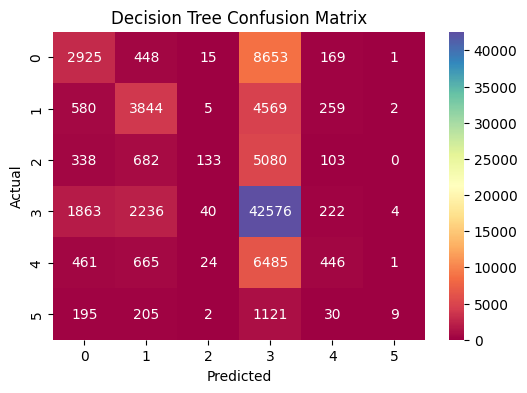

               Accuracy  Precision    Recall        F1
Decision Tree  0.591686   0.554676  0.591686  0.517002


In [ ]:
# train_test split
X_train, X_test, y_train, y_test = split_data(features, labels)
# fit and predict with model
print("\nClassification Results with Decision Tree (without embedding) with test dataset:")
cls_results = train_classification(X_train, X_test, y_train, y_test)


## With embedding


Classification Results with Decision Tree (embedding included) with test dataset:
Processing time for Decision Tree: 0.01 seconds


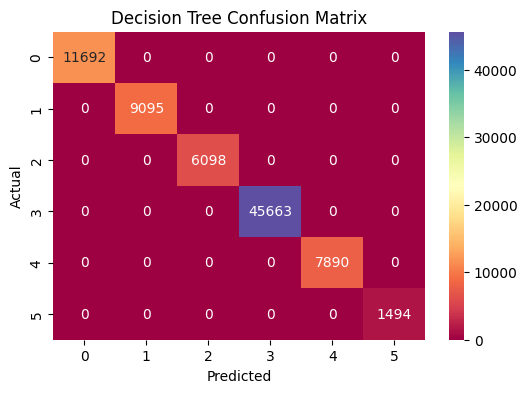

               Accuracy  Precision  Recall   F1
Decision Tree       1.0        1.0     1.0  1.0


In [ ]:
# Method 1 ( Split -> predict)
# train_test split
X_emb_train, X_emb_test, y_emb_train, y_emb_test = split_data(features_wEmbedding, labels_wEmbedding)
# fit and predict with model
print("\nClassification Results with Decision Tree (embedding included) with test dataset:")
cls_results_emb = train_classification(X_emb_train, X_emb_test, y_emb_train, y_emb_test)


Classification Results with Decision Tree (embedding included) with test dataset:
Processing time for Decision Tree: 0.01 seconds


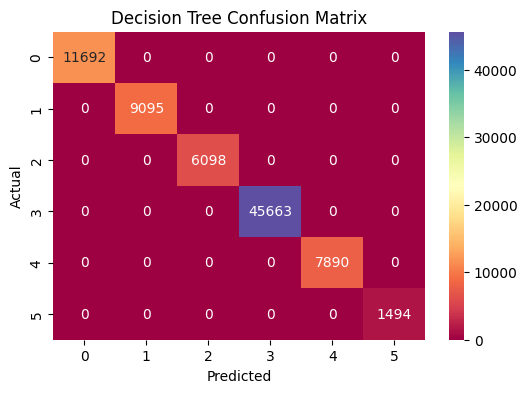

               Accuracy  Precision  Recall   F1
Decision Tree       1.0        1.0     1.0  1.0


In [ ]:
# Method 2 ( Split -> with PCA on training set ->predict)

# train_test split
X_emb_train, X_emb_test, y_emb_train, y_emb_test = split_data(features_wEmbedding, labels_wEmbedding)

#  Reduce to 100 features (adjust as needed)
pca = PCA(n_components=100, random_state=42)
X_emb_train_reduced = pca.fit_transform(X_emb_train) # has 100 columns after reducing with PCA on the train dataset
X_emb_test_reduced = pca.transform(X_emb_test)

# fit and predict with model
print("\nClassification Results with Decision Tree (embedding included) with test dataset:")
cls_results_emb = train_classification(X_emb_train_reduced, X_emb_test_reduced, y_emb_train, y_emb_test)



Classification Results with Decision Tree (embedding included) with test dataset:
Processing time for Decision Tree: 0.01 seconds


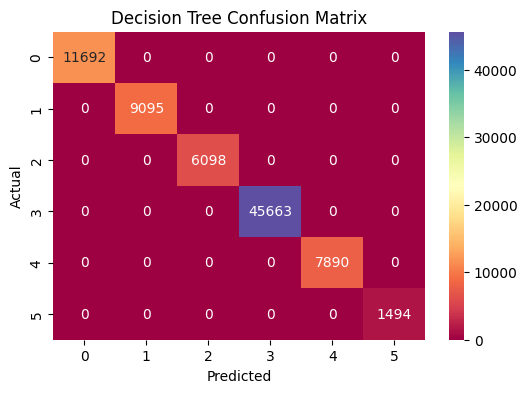

               Accuracy  Precision  Recall   F1
Decision Tree       1.0        1.0     1.0  1.0


In [ ]:
# Method 3 ( Split -> downsampling training set to 50% -> impute -> scale -> model fit -> predict)
# train_test split
X_emb_train, X_emb_test, y_emb_train, y_emb_test = split_data(features_wEmbedding, labels_wEmbedding)

# Downsample - maintain alignment between X and y
train_indices = X_emb_train.index
sampled_indices = np.random.RandomState(42).choice(train_indices, size=int(len(train_indices)*0.5), replace=False)
X_emb_train = X_emb_train.loc[sampled_indices]
y_emb_train = y_emb_train.loc[sampled_indices]

# fit and predict with model
print("\nClassification Results with Decision Tree (embedding included) with test dataset:")
cls_results_emb = train_classification(X_emb_train, X_emb_test, y_emb_train, y_emb_test)

# Plot Bar Chart

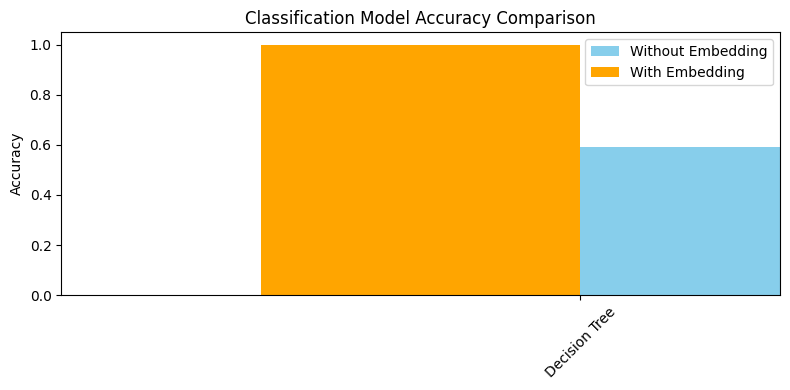

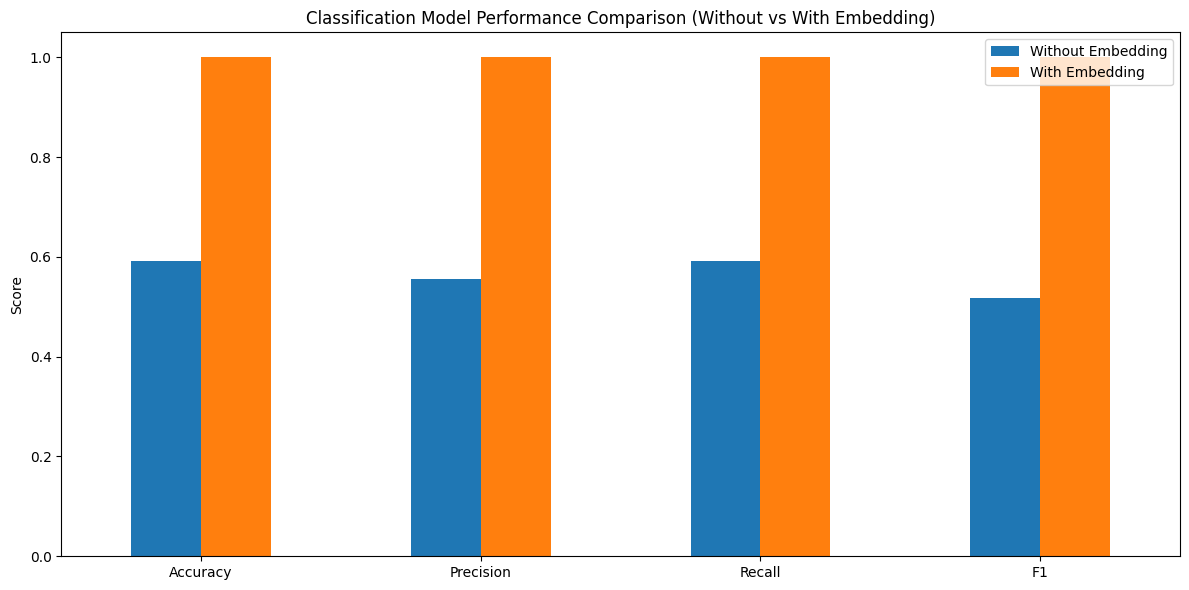


Classification Results (Without Embedding):
               Accuracy  Precision    Recall        F1
Decision Tree  0.591686   0.554676  0.591686  0.517002

Classification Results (With Embedding):
               Accuracy  Precision  Recall   F1
Decision Tree       1.0        1.0     1.0  1.0


In [ ]:
# Classification Metrics Comparison for both without and with embedding

plt.figure(figsize=(8,4))
cls_results['Accuracy'].plot(kind='bar', position=0, width=0.4, label='Without Embedding', color='skyblue')
cls_results_emb['Accuracy'].plot(kind='bar', position=1, width=0.4, label='With Embedding', color='orange')
plt.title('Classification Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# For all metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
comparison_df = pd.DataFrame({
    'Without Embedding': cls_results.loc[:, metrics].iloc[0],
    'With Embedding': cls_results_emb.loc[:, metrics].iloc[0]
}, index=metrics)

comparison_df.plot(kind='bar', figsize=(12,6))
plt.title('Classification Model Performance Comparison (Without vs With Embedding)')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print numerical results
print("\nClassification Results (Without Embedding):")
print(cls_results)
print("\nClassification Results (With Embedding):")
print(cls_results_emb)